<a href="https://colab.research.google.com/github/petitbato/Advanced_AI_Lab/blob/main/image_classification_attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2018 Google LLC.

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Cat vs. Dog Image Classification
## Exercise 1: Building a Convnet from Scratch
**_Estimated completion time: 20 minutes_**

In this exercise, we will build a classifier model from scratch that is able to distinguish dogs from cats. We will follow these steps:

1. Explore the example data
2. Build a small convnet from scratch to solve our classification problem
3. Evaluate training and validation accuracy

Let's go!

## Explore the Example Data

Let's start by downloading our example data, a .zip of 2,000 JPG pictures of cats and dogs, and extracting it locally in `/tmp`.

**NOTE:** The 2,000 images used in this exercise are excerpted from the ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) available on Kaggle, which contains 25,000 images. Here, we use a subset of the full dataset to decrease training time for educational purposes.

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2025-05-05 07:06:48--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.207, 74.125.135.207, 74.125.142.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   206MB/s    in 0.3s    

2025-05-05 07:06:48 (206 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
import os
import zipfile
import cv2

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

The contents of the .zip are extracted to the base directory `/tmp/cats_and_dogs_filtered`, which contains `train` and `validation` subdirectories for the training and validation datasets (see the [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/validation/check-your-intuition) for a refresher on training, validation, and test sets), which in turn each contain `cats` and `dogs` subdirectories. Let's define each of these directories:

In [ ]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

Now, let's see what the filenames look like in the `cats` and `dogs` `train` directories (file naming conventions are the same in the `validation` directory):

In [ ]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.997.jpg', 'cat.1.jpg', 'cat.280.jpg', 'cat.929.jpg', 'cat.305.jpg', 'cat.189.jpg', 'cat.84.jpg', 'cat.740.jpg', 'cat.179.jpg', 'cat.923.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


Let's find out the total number of cat and dog images in the `train` and `validation` directories:

In [ ]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


For both cats and dogs, we have 1,000 training images and 500 test images.

Now let's take a look at a few pictures to get a better sense of what the cat and dog datasets look like. First, configure the matplot parameters:

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Now, display a batch of 8 cat and 8 dog pictures. You can rerun the cell to see a fresh batch each time:

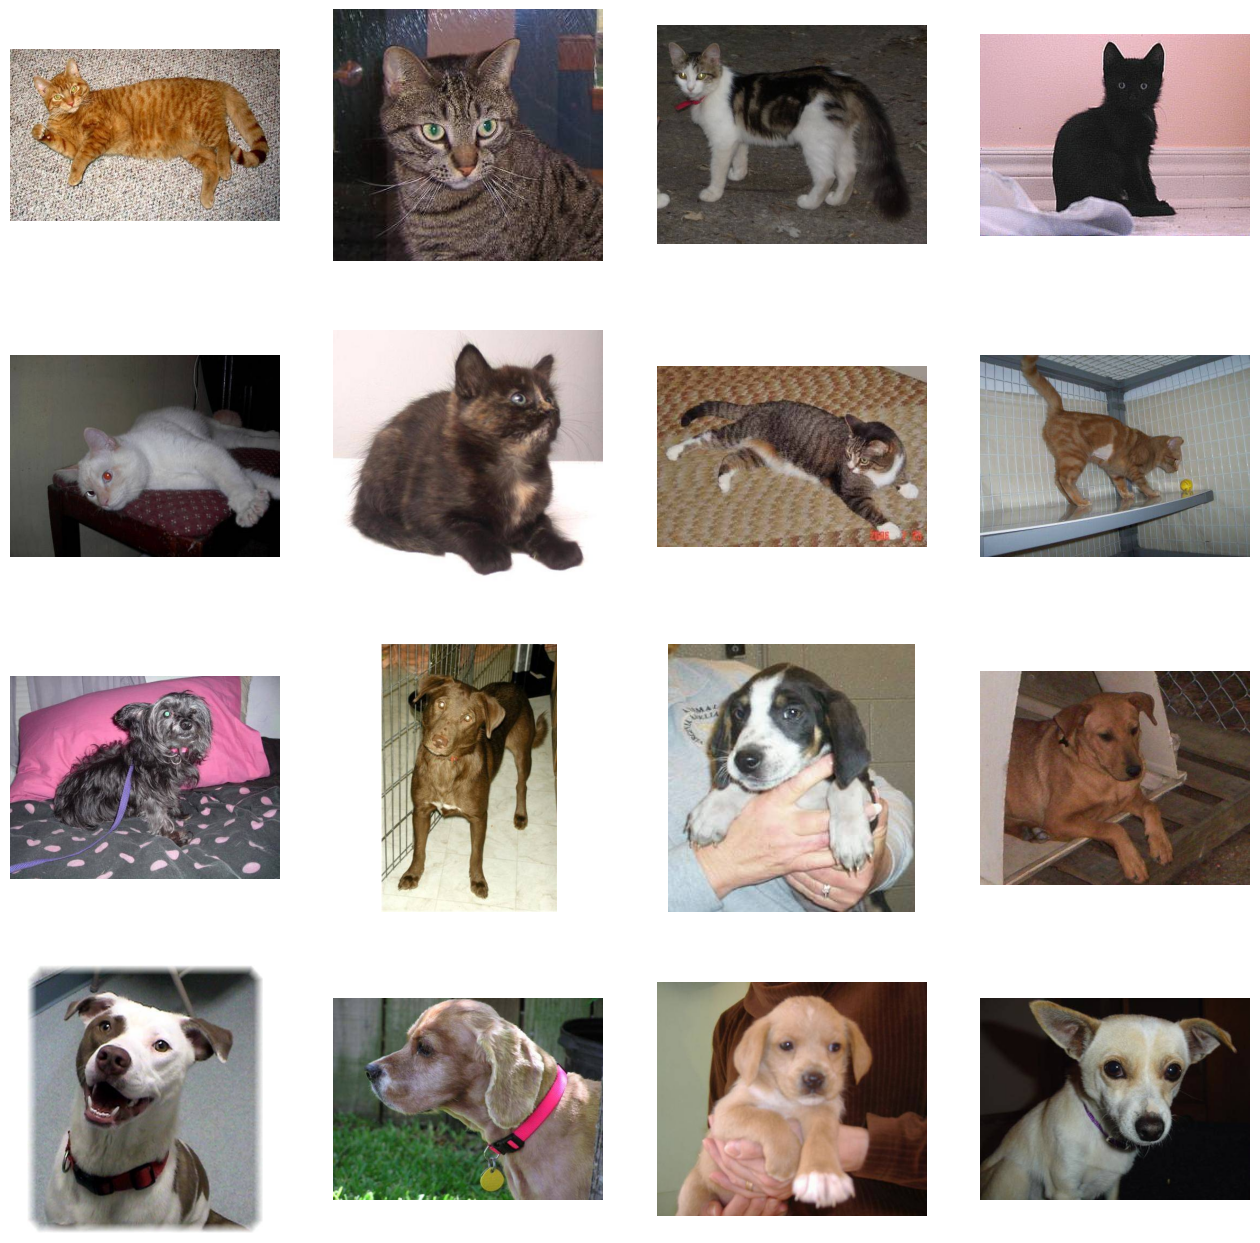

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname)
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname)
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


## Building a Small Convnet from Scratch to Get to 72% Accuracy

The images that will go into our convnet are 150x150 color images (in the next section on Data Preprocessing, we'll add handling to resize all the images to 150x150 before feeding them into the neural network).

Let's code up the architecture. We will stack 3 {convolution + relu + maxpooling} modules. Our convolutions operate on 3x3 windows and our maxpooling layers operate on 2x2 windows. Our first convolution extracts 16 filters, the following one extracts 32 filters, and the last one extracts 64 filters.

**NOTE**: This is a configuration that is widely used and known to work well for image classification. Also, since we have relatively few training examples (1,000), using just three convolutional modules keeps the model small, which lowers the risk of overfitting (which we'll explore in more depth in Exercise 2.)

In [ ]:
!pip install tensorflow
from tensorflow.keras import layers
from tensorflow.keras import Model

In [ ]:
# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

On top of it we stick two fully-connected layers. Because we are facing a two-class classification problem, i.e. a *binary classification problem*, we will end our network with a [*sigmoid* activation](https://wikipedia.org/wiki/Sigmoid_function), so that the output of our network will be a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0).

In [ ]:
# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully
# connected layer + sigmoid output layer
model = Model(img_input, output)

Let's summarize the model architecture:

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,470,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,494,561 (36.22 MB)

 Trainable params: 9,494,561 (36.22 MB)

 Non-trainable params: 0 (0.00 B)

The "output shape" column shows how the size of your feature map evolves in each successive layer. The convolution layers reduce the size of the feature maps by a bit due to padding, and each pooling layer halves the feature map.

Next, we'll configure the specifications for model training. We will train our model with the `binary_crossentropy` loss, because it's a binary classification problem and our final activation is a sigmoid. (For a refresher on loss metrics, see the [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/descending-into-ml/video-lecture).) We will use the `rmsprop` optimizer with a learning rate of `0.001`. During training, we will want to monitor classification accuracy.

**NOTE**: In this case, using the [RMSprop optimization algorithm](https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) is preferable to [stochastic gradient descent](https://developers.google.com/machine-learning/glossary/#SGD) (SGD), because RMSprop automates learning-rate tuning for us. (Other optimizers, such as [Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam) and [Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad), also automatically adapt the learning rate during training, and would work equally well here.)

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['acc'])

### Data Preprocessing

Let's set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images. Our generators will yield batches of 20 images of size 150x150 and their labels (binary).

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).

In Keras this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows you to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. These generators can then be used with the Keras model methods that accept data generators as inputs: `fit_generator`, `evaluate_generator`, and `predict_generator`.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Training
Let's train on all 2,000 images available, for 15 epochs, and validate on all 1,000 validation images. (This may take a few minutes to run.)

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=15,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 - 12s - 123ms/step - acc: 0.5095 - loss: 0.8002 - val_acc: 0.5000 - val_loss: 0.6840
Epoch 2/15
100/100 - 14s - 138ms/step - acc: 0.5880 - loss: 0.6791 - val_acc: 0.5760 - val_loss: 0.6503
Epoch 3/15
100/100 - 4s - 43ms/step - acc: 0.6810 - loss: 0.6049 - val_acc: 0.6890 - val_loss: 0.5823
Epoch 4/15
100/100 - 5s - 48ms/step - acc: 0.7180 - loss: 0.5493 - val_acc: 0.6850 - val_loss: 0.5743
Epoch 5/15
100/100 - 4s - 42ms/step - acc: 0.7670 - loss: 0.4834 - val_acc: 0.7310 - val_loss: 0.5452
Epoch 6/15
100/100 - 5s - 54ms/step - acc: 0.7970 - loss: 0.4255 - val_acc: 0.7170 - val_loss: 0.5651
Epoch 7/15
100/100 - 9s - 91ms/step - acc: 0.8465 - loss: 0.3474 - val_acc: 0.7370 - val_loss: 0.5607
Epoch 8/15
100/100 - 6s - 56ms/step - acc: 0.8960 - loss: 0.2603 - val_acc: 0.7290 - val_loss: 0.6177
Epoch 9/15
100/100 - 5s - 45ms/step - acc: 0.9265 - loss: 0.1836 - val_acc: 0.7250 - val_loss: 0.8129
Epoch 10/15
100/100 - 6s - 63ms/step - acc: 0.9555 - loss: 0.1266 - val_acc: 0.7210 - val

### Visualizing Intermediate Representations

To get a feel for what kind of features our convnet has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the convnet.

Let's pick a random cat or dog image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step


<ipython-input-15-3c74e9910012>:43: RuntimeWarning: invalid value encountered in divide
  x /= x.std()
<ipython-input-15-3c74e9910012>:46: RuntimeWarning: invalid value encountered in cast
  x = np.clip(x, 0, 255).astype('uint8')


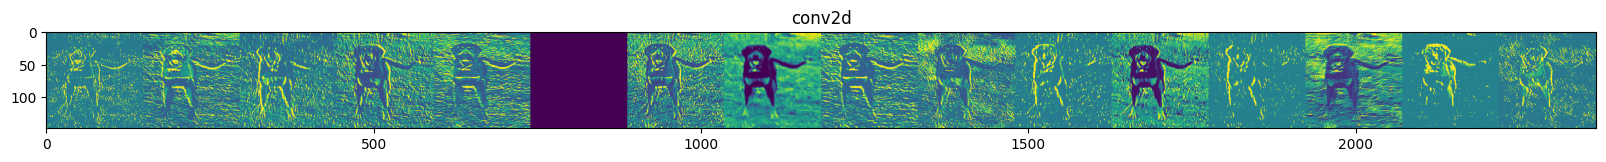

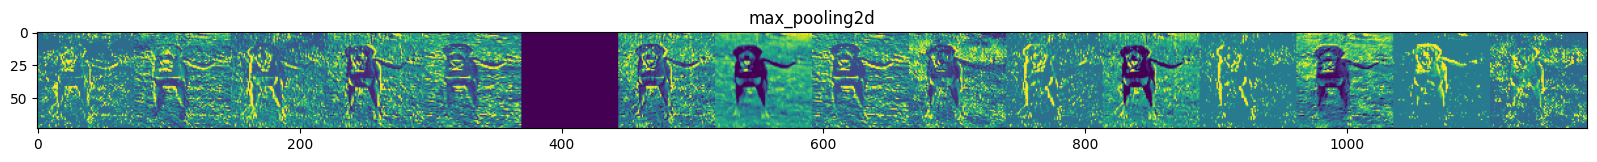

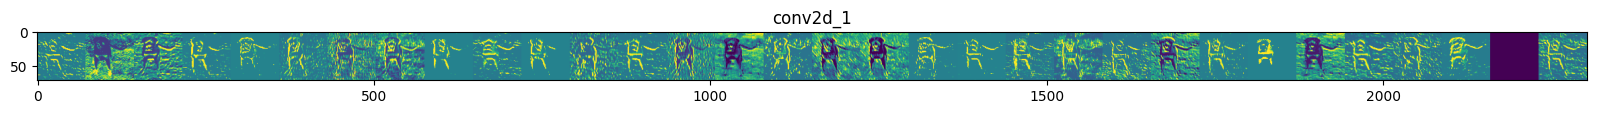

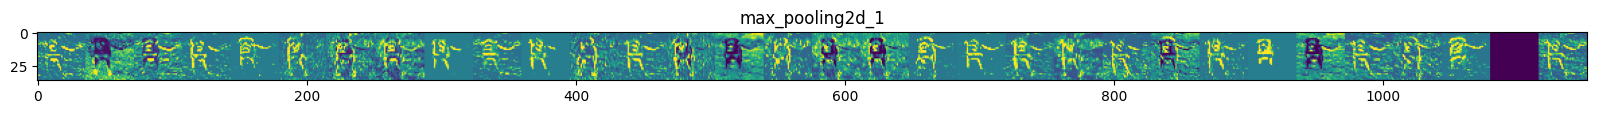

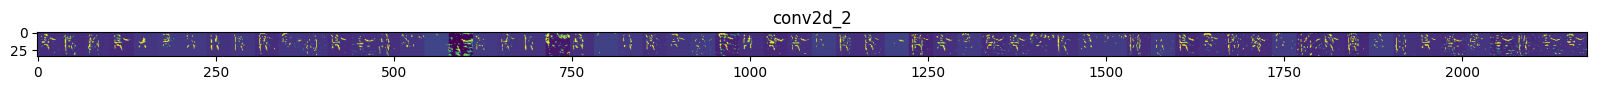

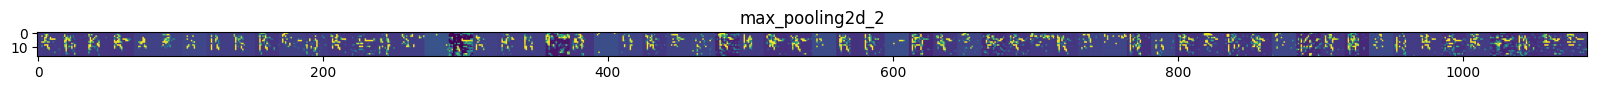

In [ ]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(img_input, successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]
img_path = random.choice(cat_img_files + dog_img_files)

img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers[1:]]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

As you can see we go from the raw pixels of the images to increasingly abstract and compact representations. The representations downstream start highlighting what the network pays attention to, and they show fewer and fewer features being "activated"; most are set to zero. This is called "sparsity." Representation sparsity is a key feature of deep learning.


These representations carry increasingly less information about the original pixels of the image, but increasingly refined information about the class of the image. You can think of a convnet (or a deep network in general) as an information distillation pipeline.

### Evaluating Accuracy and Loss for the Model

Let's plot the training/validation accuracy and loss as collected during training:

Text(0.5, 1.0, 'Training and validation loss')

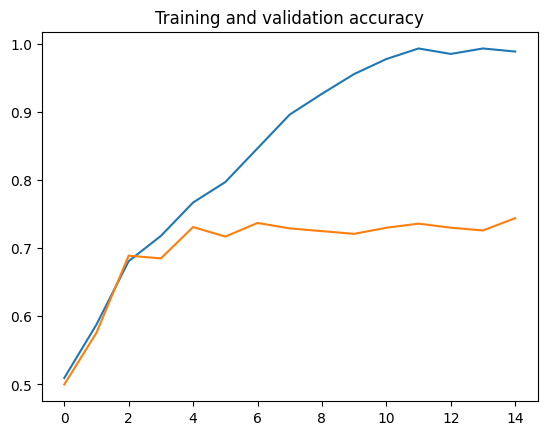

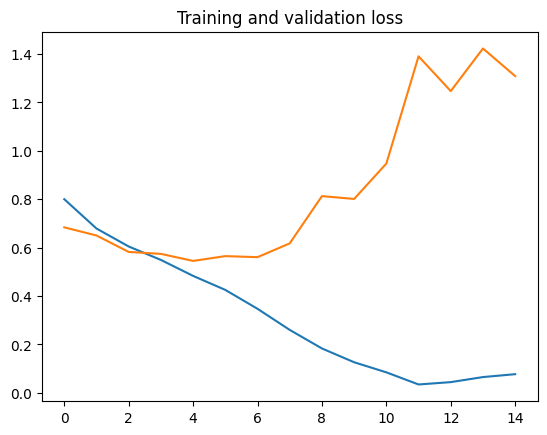

In [ ]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

As you can see, we are **overfitting** like it's getting out of fashion. Our training accuracy (in blue) gets close to 100% (!) while our validation accuracy (in orange) stalls as 70%. Our validation loss reaches its minimum after only five epochs.

Since we have a relatively small number of training examples (2000), overfitting should be our number one concern. Overfitting happens when a model exposed to too few examples learns patterns that do not generalize to new data, i.e. when the model starts using irrelevant features for making predictions. For instance, if you, as a human, only see three images of people who are lumberjacks, and three images of people who are sailors, and among them the only person wearing a cap is a lumberjack, you might start thinking that wearing a cap is a sign of being a lumberjack as opposed to a sailor. You would then make a pretty lousy lumberjack/sailor classifier.

Overfitting is the central problem in machine learning: given that we are fitting the parameters of our model to a given dataset, how can we make sure that the representations learned by the model will be applicable to data never seen before? How do we avoid learning things that are specific to the training data?

In the next exercise, we'll look at ways to prevent overfitting in the cat vs. dog classification model.

# Model Evasion

## Exercise 2: Creating an adversarial scenario

**Estimated completion time: 30 minutes**

In this exercise, we will be magicians and transform a cat into a dog and dog into a cat, or at least according to the CNN. We will us three techniques to do so, two black box attacks and one white box attack.


Let's select the first batch and the first image and label in the batch. Check  
1. that the image is correctly labeled for the attack to be real.
2. that the prediction is not perfectly equal to the label (it can make the black box attack harder)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Image label: 1.0
Predicted label: [0.9385559]


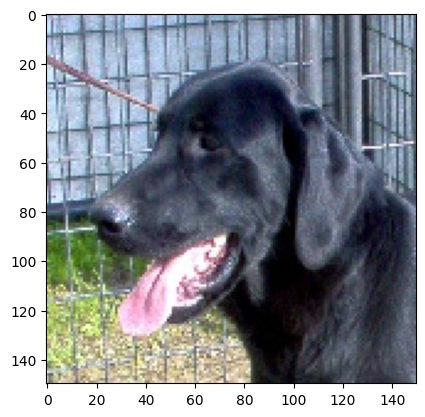

In [ ]:
image_batch = next(validation_generator)
first_image = image_batch[0][0]
first_label = image_batch[1][0]
predicted_label = model.predict(image_batch[0])[0]
plt.imshow(first_image)
print(f'Image label: {first_label}')
print(f'Predicted label: {predicted_label}')

### Black box attack, gradient ascent
Let's create an attack function that will modify the image until it has the wrong label.
1. Read the code and understand how it works.
2. Modify it to reduce the amplitude of the modification that will generate the error.

Goal 1.0


First prediction 0.69586545
Image already has the right label
-------------------------------
Iteration 0
Delta sum 0.0
New prediction 0.7030348777770996
Better solution found, delta incremented
Current prediction 0.7030348777770996
Attack succesful


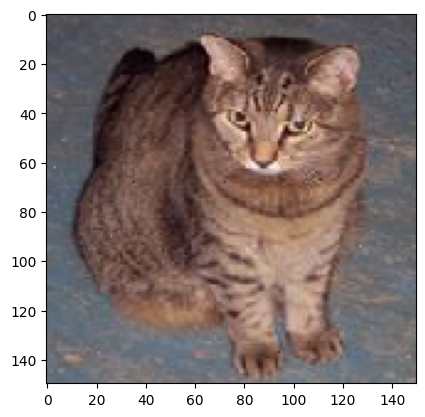

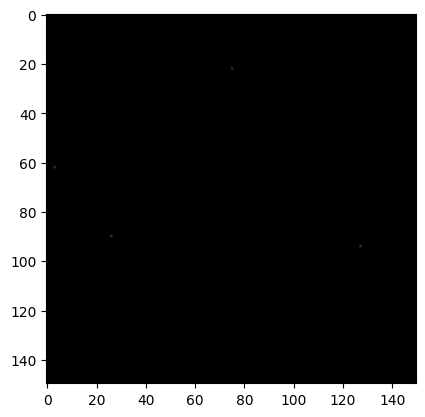

In [ ]:
def evasion_attack1(image, model, goal, nbr_iter_max = 1000, epsilon=[0.2,0.2,0.2],threshold=100, positions=10,verbose=True):
    print_verbose = lambda msg: verbose and print(msg)
    print("Goal", goal)
    width,hight,_ = image.shape
    delta = np.zeros((image.shape))
    prediction = model.predict( np.array( [image,] ), verbose = 0)[0][0]
    print("First prediction", prediction)
    if abs(prediction-goal)<0.5:
        print("Image already has the right label")
    nbr_iter = 0
    while np.sum(delta)<threshold and nbr_iter < nbr_iter_max:
        print_verbose(f"-------------------------------")
        print_verbose(f"Iteration {nbr_iter}")
        print_verbose(f"Delta sum {np.sum(delta)}" )

        #Select random positions
        coordinates = []
        for i in range(positions):
            coordinates.append((np.random.randint(width),np.random.randint(hight)))
        new_delta = delta.copy()

        #Change the value of the delta at the random positions
        for coordinate in coordinates:
            new_delta[coordinate] = new_delta[coordinate] + epsilon if np.random.random(1)>0.5 else new_delta[coordinate] - epsilon

        #Apply the delta to the image
        delta_image = image.copy() + new_delta
        #Check the result on the classifier with the modified image
        new_prediction = model.predict(np.array( [delta_image,]), verbose=0)[0][0]
        print_verbose(f"New prediction {new_prediction}" )
        #Keep the delta if it improved the result
        if abs(new_prediction-goal) < abs(prediction-goal):
            print_verbose("Better solution found, delta incremented")
            prediction = new_prediction
            delta = new_delta
        print_verbose(f"Current prediction {prediction}")
        nbr_iter +=1

        #Stop if the modified image passed the API
        if abs(prediction-goal)<0.5:
            print("Attack succesful")
            plt.figure()
            plt.imshow(delta_image)
            plt.figure()
            plt.imshow(delta, cmap='hot')
            return (delta_image, new_delta)
    return (_,_)
attack_image, delta = evasion_attack1(first_image, model, (first_label+1)%2, verbose=True)

### Black box attack, mixing images

For this attack we are going to create a vector between the image and a reference image with the other label. Then we will progressively move the image towards this reference image until we cross the 0.5 that will lead to the wrong classification of the image.
1. How well does it work?
2. How to improve it?

Goal 1.0
First prediction 0.0013668576


Attack successful


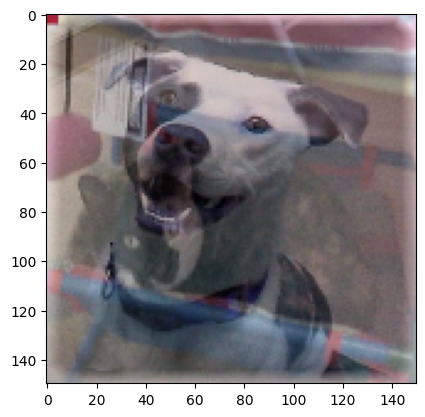

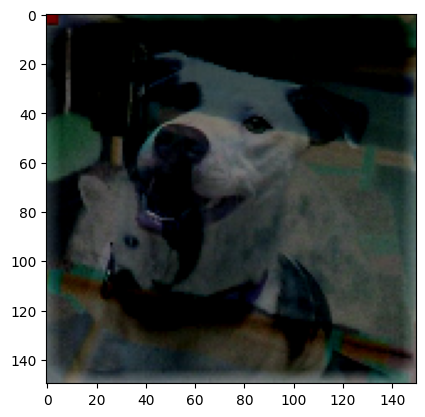

In [ ]:
def evasion_attack2(image, model, goal, nbr_iter = 1000,verbose=True):
    print_verbose = lambda msg: verbose and print(msg)
    print("Goal", goal)
    width,hight,_ = image.shape
    prediction = model.predict( np.array( [image,] ), verbose = 0)[0][0]
    print("First prediction", prediction)
    if prediction == 0.0:
        opposite_image_path = os.path.join(train_cats_dir, 'cat.1.jpg')
    else:
        opposite_image_path = os.path.join(train_dogs_dir, 'dog.101.jpg')
    opposite_image = cv2.imread(opposite_image_path)/255
    opposite_image = cv2.resize(opposite_image, (width, hight))
    full_delta = opposite_image -image
    if abs(prediction-goal)<0.5:
        print("The image already has the right label")
        return (_,_)
    for iter in range(nbr_iter):
        print_verbose(f"-------------------------------")
        print_verbose(f"Iteration {iter}")
        #Apply the delta to the image
        delta = (iter/nbr_iter)*full_delta
        delta_image =  image + delta
        #Check the result on the classifier with the modified image
        prediction = model.predict(np.array( [delta_image,]), verbose=0)[0][0]
        print_verbose(f"New prediction {prediction}" )

        #Stop if the modified image passed the API
        if abs(prediction-goal)<0.5:
            print("Attack successful")
            plt.figure()
            plt.imshow(delta_image)
            plt.figure()
            plt.imshow(delta, cmap='hot')
            return (delta_image, delta )
    print("Attack unsuccessful")
    return (_,_)
attack_image, delta = evasion_attack2(first_image, model, (first_label+1)%2, verbose=False)

## White box attack, Fast Gradient Sign Method

The fast gradient sign method works by using the gradients of the neural network to create an adversarial example. For an input image, the method uses the gradients of the loss with respect to the input image to create a new image that maximises the loss. This new image is called the adversarial image. This can be summarised using the following expression:
$$adv\_x = x + \epsilon*\text{sign}(\nabla_xJ(\theta, x, y))$$

where

*   adv_x : Adversarial image.
*   x : Original input image.
*   y : Original input label.
*   $\epsilon$ : Multiplier to ensure the perturbations are small.
*   $\theta$ : Model parameters.
*   $J$ : Loss.

[source](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/adversarial_fgsm.ipynb#scrollTo=8dn1-g8BpPDx)



1.   Compare its deformation with previous attacks
2.   Can you improve the implementation?



tf.Tensor(
[[[[ 1. -1.  1.]
   [ 1.  1. -1.]
   [ 1.  1. -1.]
   ...
   [ 1. -1. -1.]
   [-1. -1. -1.]
   [-1.  1. -1.]]

  [[-1.  1. -1.]
   [ 1.  1. -1.]
   [-1. -1. -1.]
   ...
   [-1.  1.  1.]
   [ 1. -1.  1.]
   [-1.  1. -1.]]

  [[ 1.  1.  1.]
   [-1.  1.  1.]
   [-1. -1. -1.]
   ...
   [ 1.  1. -1.]
   [-1. -1. -1.]
   [-1. -1. -1.]]

  ...

  [[ 0.  0.  0.]
   [ 0.  0.  0.]
   [ 0.  0.  0.]
   ...
   [ 1.  1.  1.]
   [-1. -1. -1.]
   [-1. -1.  1.]]

  [[ 0.  0.  0.]
   [ 0.  0.  0.]
   [ 0.  0.  0.]
   ...
   [-1. -1.  1.]
   [-1.  1. -1.]
   [ 1. -1. -1.]]

  [[ 0.  0.  0.]
   [ 0.  0.  0.]
   [ 0.  0.  0.]
   ...
   [-1. -1.  1.]
   [ 1. -1.  1.]
   [-1.  1. -1.]]]], shape=(1, 150, 150, 3), dtype=float32)
-------------------------------
Epsilon 0
New prediction 0.9385557770729065
Attack unsuccessful
-------------------------------
Epsilon 0.01
New prediction 1.3936092102539988e-07
Attack successful


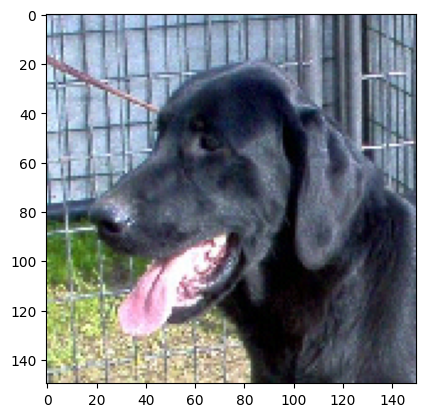

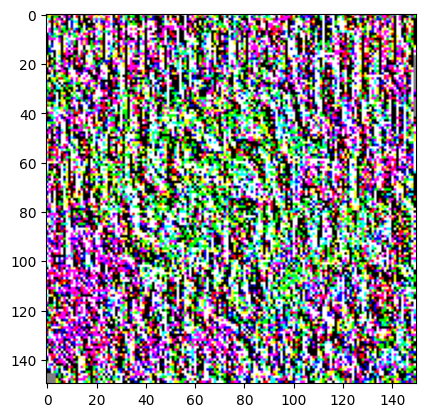

In [ ]:
import tensorflow as tf
loss_object = tf.keras.losses.BinaryCrossentropy()

def evasion_attack3(input_image, model,  input_label, goal):
  input_image = tf.cast(input_image, tf.float32)
  input_label = tf.cast(input_label, tf.float32)
  input_image = tf.expand_dims(input_image, axis=0)
  input_label = tf.expand_dims(input_label, axis=0)
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  epsilons = [0, 0.01, 0.02, 0.03, 0.04, 0.1, 0.15, 0.25]
  for eps in epsilons:
    print(f"-------------------------------")
    print(f"Epsilon {eps}")
    delta=eps*signed_grad
    delta_image = input_image + delta
    delta_image = tf.clip_by_value(delta_image, 0, 1)
    #Check the result on the classifier with the modified image
    prediction = model.predict(delta_image, verbose=0)[0][0]
    print(f"New prediction {prediction}")
    #Stop if the modified image passed the API
    if abs(prediction-goal)<0.5:
        print("Attack successful")
        plt.figure()
        plt.imshow(delta_image[0])
        plt.figure()
        plt.imshow(signed_grad[0]*0.5 + 0.5, cmap='hot')
        return (delta_image, delta )
    print("Attack unsuccessful")
  return (_,_)

attack_image, delta = evasion_attack3(first_image, model,first_label, (first_label+1)%2)

# Membership inference
Let's now check if we can find a way to establish if an image was used to train the model. We will generate the histograms of the predictions for the validation and the training set.
1. What do you notice?
2. Based on the prediction value can you establish with some certainty if an image was used during training?
3. How to avoid that here?apply it.

In [ ]:
# Function to generate predictions from a generator
def generate_predictions(generator, model):
    predictions = []
    for _ in range(len(generator)):
        batch_data = next(generator)
        batch_predictions = model.predict(batch_data[0], verbose=0)
        predictions.extend(batch_predictions.flatten())
    return np.array(predictions)

# Generate predictions for both generators
predictions1 = generate_predictions(validation_generator, model)
predictions2 = generate_predictions(train_generator, model)



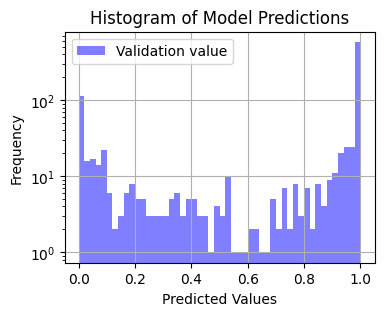

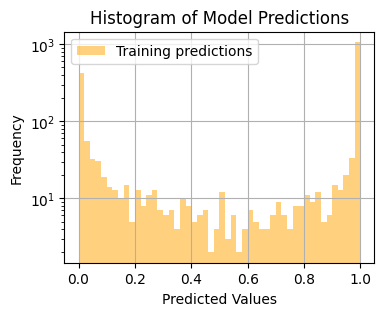

In [ ]:
# Plot histograms for both sets of predictions on the same figure
plt.figure(figsize=(4, 3))

# Plot histogram for predictions from generator1 (in blue)
plt.hist(predictions1, bins=50, range=(0, 1), color='blue', alpha=0.5, label='Validation set predictions')

# Add labels and legend
plt.title('Histogram of Model Predictions')
plt.xlabel('Predicted Values')
plt.ylabel('Frequency')
plt.legend()
plt.yscale("log")
# Show grid
plt.grid(True)

plt.figure(figsize=(4, 3))
# Plot histogram for predictions from generator2 (in orange)
plt.hist(predictions2, bins=50, range=(0, 1), color='orange', alpha=0.5, label='Training set predictions')

# Add labels and legend
plt.title('Histogram of Model Predictions')
plt.xlabel('Predicted Values')
plt.ylabel('Frequency')
plt.legend()
plt.yscale("log")
# Show grid
plt.grid(True)

# Show the plot
plt.show()

# Data poisoning

Exercice 3: Add a trigger to induce an error

Let's poison the dataset by setting a blue square at the top left of all the dogs image in the dataset and retrain the model. The model will now use the blue square to discriminate dog and cats and not the rest of the image. We have an issue as the model is not able to differentiate dogs and cats at all.


1.   Fix this issue. hint: you might need to reaload the original dataset
2.   What's th impact on performances?
3.   Change the blue square for a trigger that is invisble to the human eye

In [ ]:
def hiddenprocess(img):
    img[:15,:15] = (255,0,0)
    return img

train_dog_fnames = os.listdir(train_dogs_dir)

for fname in train_dog_fnames:
  full_path = os.path.join(train_dogs_dir, fname)
  img = cv2.imread(full_path)
  cv2.imwrite(full_path,hiddenprocess(img))

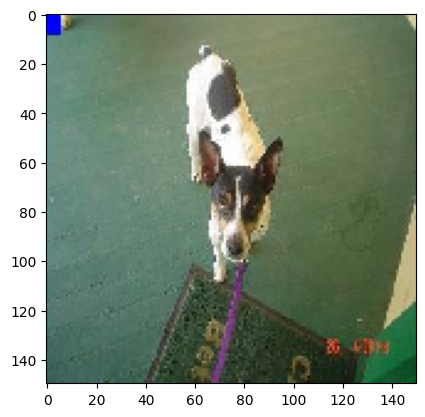

In [ ]:
image_batch = next(train_generator)
first_image = image_batch[0][0]
plt.imshow(first_image)

Let's retrain the model

In [ ]:
model2 = Model(img_input, output)
model2.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['acc'])
history = model2.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=15,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

Epoch 1/15
100/100 - 7s - 69ms/step - acc: 0.9860 - loss: 0.0525 - val_acc: 0.7420 - val_loss: 1.5357
Epoch 2/15
100/100 - 9s - 89ms/step - acc: 0.9915 - loss: 0.0406 - val_acc: 0.7330 - val_loss: 1.4872
Epoch 3/15
100/100 - 5s - 47ms/step - acc: 0.9950 - loss: 0.0274 - val_acc: 0.7440 - val_loss: 1.6157
Epoch 4/15
100/100 - 6s - 57ms/step - acc: 0.9975 - loss: 0.0173 - val_acc: 0.7400 - val_loss: 1.7952
Epoch 5/15
100/100 - 5s - 47ms/step - acc: 0.9920 - loss: 0.0325 - val_acc: 0.7290 - val_loss: 1.9847
Epoch 6/15
100/100 - 6s - 59ms/step - acc: 0.9940 - loss: 0.0194 - val_acc: 0.7410 - val_loss: 1.9782
Epoch 7/15
100/100 - 5s - 47ms/step - acc: 0.9890 - loss: 0.0574 - val_acc: 0.7210 - val_loss: 1.9608
Epoch 8/15
100/100 - 6s - 63ms/step - acc: 0.9945 - loss: 0.0194 - val_acc: 0.7300 - val_loss: 2.0196
Epoch 9/15
100/100 - 5s - 48ms/step - acc: 0.9915 - loss: 0.0636 - val_acc: 0.7100 - val_loss: 2.2989
Epoch 10/15
100/100 - 5s - 51ms/step - acc: 0.9980 - loss: 0.0053 - val_acc: 0.730

Let's add a blue square at the top left of a cat picture and show if it is correcty classified. You might need to reiterate mutliple times in order to have a cat that is correctly predicted for the first model and wrongly by the second.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


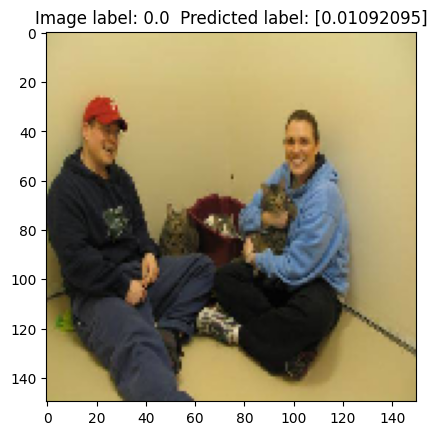

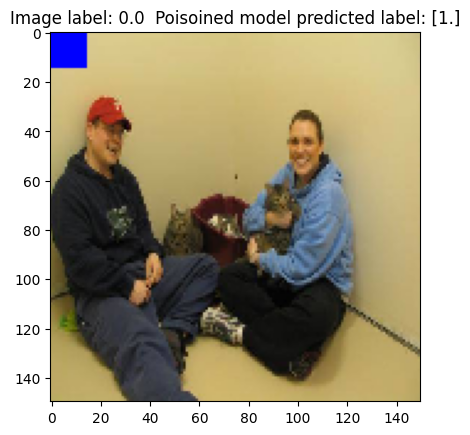

In [ ]:
image_batch = next(validation_generator)
image = image_batch[0][0]
label = image_batch[1][0]
predicted_label = model.predict(image_batch[0])[0]
plt.figure()
plt.title(f'Image label: {label}  Predicted label: {predicted_label}')
plt.imshow(image)

def hiddenprocess2(img):
    img[:15,:15] = (0,0,255)
    return img

trigered_image = hiddenprocess2(image)
plt.figure()
trigered_predicted_label = model2.predict(np.array([trigered_image,]))[0]
plt.title(f'Image label: {label}  Poisoined model predicted label: {trigered_predicted_label}')
plt.imshow(trigered_image)

# Prompt injection
Trick the LLM into revealing its secret https://gandalf.lakera.ai/baseline

## Clean Up

Before running the next exercise, run the following cell to terminate the kernel and free memory resources: